In [68]:
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from utils.data import load_tc_data
from utils.plot import make_cmap
import cftime as cf
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from numpy import inf
# from utils.evaluation import find_landfalling_tcs,tc_region

In [69]:
precip_cmap,precip_norm = make_cmap()
levels = [10, 15, 20, 25, 30, 40, 50,75, 100]

In [70]:
# open storm dataset

# define filenames and paths
tc_dir = '/user/home/al18709/work/event_sets/wgan_modular/'
tc_dir_truth = '/user/home/al18709/work/event_sets/truth/'
storm = '2006237N13298'
storm_filename = f'validation_mraw_{storm}.nc'
storm_filename2 = f'validation_1and2_{storm}.nc'

# load storm scores
storm_scores = np.load(tc_dir + f'validation_mraw_critic_{storm}.npy')
storm_scores2 = np.load(tc_dir + f'validation_1and2_critic_{storm}.npy')

# load rain data
storm = xr.open_dataset(tc_dir + storm_filename)
storm2 = xr.open_dataset(tc_dir + storm_filename2)
storm_truth = xr.open_dataset(tc_dir_truth + f'validation_2006237N13298.nc')


In [71]:
# define initial variables
precip_cmap,precip_norm = make_cmap()

lats = storm.storm_lats[0,:,:]
lons = storm.storm_lons[0,:,:]

levels = [10, 15, 20, 25, 30, 40, 50, 75, 100]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=100
ntime,_,_,_ = storm.precipitation.shape

rain = storm.precipitation[0,:,:,0]
rain2 = storm2.precipitation[0,:,:,0]
rain_truth = storm_truth.precipitation[0,:,:,0]


In [72]:
# find storm extent
fp = '/bp1/geog-tropical/data/Obs/MSWEP/3hourly_invertlat/2000342.00.nc'
d = Dataset(fp, 'r')
lat = d.variables['lat'][:] #lat
lon = d.variables['lon'][:] #lon
lat_lower_bound = (np.abs(lat-np.min(storm.storm_lats))).argmin()
lat_upper_bound = (np.abs(lat-np.max(storm.storm_lats))).argmin()
lon_lower_bound = (np.abs(lon-np.min(storm.storm_lons))).argmin()
lon_upper_bound = (np.abs(lon-np.max(storm.storm_lons))).argmin()

lats = lat[lat_lower_bound:lat_upper_bound+2]
lons = lon[lon_lower_bound:lon_upper_bound+2]
grid_x, grid_y = np.meshgrid(lons,lats)
print(grid_x.shape)
print(grid_y.shape)

(326, 252)
(326, 252)


In [73]:
# superimpose rain onto bigger grid
grid_rain = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain2 = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1],20))
grid_rain_combo = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))
grid_rain_truth = np.zeros((ntime,grid_x.shape[0],grid_y.shape[1]))

for t in range(ntime):

	storm_lons = storm.storm_lons[t,:,:]
	storm_lats = storm.storm_lats[t,:,:]
	
	storm_rain_truth = storm_truth.precipitation[t,:,:,0]

	Mlon = storm_lons[-1,-1]
	mlon = storm_lons[0,0]
	Mlat = storm_lats[-1,-1]
	mlat = storm_lats[0,0]
	Xspan = np.where((grid_x <= Mlon) & (grid_x >= mlon))[1][[0, -1]]
	Yspan = np.where((grid_y <= Mlat) & (grid_y >= mlat))[0][[0, -1]]

	# Create a selection
	sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]
	# sel = [slice(Xspan[0] - 1, Xspan[1]), slice(Yspan[0] - 1, Yspan[1])]
	# sel = [slice(Yspan[0] -1, Yspan[1] + 1), slice(Xspan[0]-1, Xspan[1] + 1)]

	# grid_rain[t,sel[0],sel[1]] = storm_rain
	for i in range(20):
		storm_rain = storm.precipitation[t,:,:,i]
		grid_rain[t,sel[1],sel[0],i] = storm_rain
		storm_rain2 = storm2.precipitation[t,:,:,i]
		grid_rain2[t,sel[1],sel[0],i] = storm_rain2
		

	grid_rain_truth[t,sel[1],sel[0]] = storm_rain_truth
	

In [74]:
total_storm_rain = np.sum(grid_rain[:,:,:,0],axis=0)
total_storm_rain2 = np.sum(grid_rain2[:,:,:,0],axis=0)

total_storm_rain_truth = np.sum(grid_rain_truth,axis=0)
rain_bool = total_storm_rain > 50
rain_bool2 = total_storm_rain2 > 50

print(np.sum(rain_bool))
rain_grid_x2 = grid_x[rain_bool2]


rain_bool_truth = total_storm_rain_truth > 50
print(np.sum(rain_bool_truth))
rain_grid_x_truth = grid_x[rain_bool_truth]

4926
5084


In [75]:
# hit = (rain_bool == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss = (rain_bool == False) & (rain_bool_truth == True)
# hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
# print('Hit rate: ',hit_rate*100)

# false_alarm = (rain_bool == True) & (rain_bool_truth == False)
# correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
# false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
# print('false alarm rate',false_alarm_rate*100)

# hit2 = (rain_bool2 == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss2 = (rain_bool2 == False) & (rain_bool_truth == True)
# hit_rate2 = np.sum(hit2) / (np.sum(hit2) + np.sum(miss2))
# print('Hit rate2: ',hit_rate2*100)

# false_alarm2 = (rain_bool2 == True) & (rain_bool_truth == False)
# correct_rejection2 = (rain_bool2 == False) & (rain_bool_truth == False)
# false_alarm_rate2 = np.sum(false_alarm2)/(np.sum(false_alarm2) + np.sum(correct_rejection2))
# print('false alarm rate2',false_alarm_rate2*100)

# hit3 = (rain_bool3 == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss3 = (rain_bool3 == False) & (rain_bool_truth == True)
# hit_rate3 = np.sum(hit2) / (np.sum(hit3) + np.sum(miss3))
# print('Hit rate3: ',hit_rate3*100)

# false_alarm3 = (rain_bool3 == True) & (rain_bool_truth == False)
# correct_rejection3 = (rain_bool3 == False) & (rain_bool_truth == False)
# false_alarm_rate3 = np.sum(false_alarm3)/(np.sum(false_alarm3) + np.sum(correct_rejection3))
# print('false alarm rate3',false_alarm_rate3*100)

# hit4 = (rain_bool4 == True) & (rain_bool_truth == True)
# print(np.sum(hit))
# miss4 = (rain_bool4 == False) & (rain_bool_truth == True)
# hit_rate4 = np.sum(hit4) / (np.sum(hit4) + np.sum(miss4))
# print('Hit rate4: ',hit_rate4*100)

# false_alarm4 = (rain_bool4 == True) & (rain_bool_truth == False)
# correct_rejection4 = (rain_bool4 == False) & (rain_bool_truth == False)
# false_alarm_rate4 = np.sum(false_alarm4)/(np.sum(false_alarm4) + np.sum(correct_rejection4))
# print('false alarm rate4',false_alarm_rate4*100)

# # equitable threat score is:
# # (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
# # where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
# # http://cimss.ssec.wisc.edu/goes/comet/threat.html
# # ETS = (hits - E) / (hits + misses + false alarms - E)
# # E = (number of forecast points * number of observed points) / total number of points possible

# n_forecast_points = np.sum(rain_bool == True)
# n_observed_points = np.sum(rain_bool_truth == True)
# total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points*n_observed_points) / total_points_possible
# ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
# print('ETS: ', ETS)


# n_forecast_points2 = np.sum(rain_bool2 == True)
# n_observed_points2 = np.sum(rain_bool_truth == True)
# total_points_possible2 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points2*n_observed_points2) / total_points_possible2
# ETS = (np.sum(hit2) - E) / (np.sum(hit2) + np.sum(miss2) + np.sum(false_alarm2) - E)
# print('ETS2: ', ETS)

# n_forecast_points3 = np.sum(rain_bool3 == True)
# n_observed_points3 = np.sum(rain_bool_truth == True)
# total_points_possible3 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points3*n_observed_points3) / total_points_possible3
# ETS = (np.sum(hit3) - E) / (np.sum(hit3) + np.sum(miss3) + np.sum(false_alarm3) - E)
# print('ETS3: ', ETS)

# n_forecast_points4 = np.sum(rain_bool4 == True)
# n_observed_points4 = np.sum(rain_bool_truth == True)
# total_points_possible4 = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
# E = (n_forecast_points4*n_observed_points4) / total_points_possible4
# ETS = (np.sum(hit4) - E) / (np.sum(hit4) + np.sum(miss4) + np.sum(false_alarm4) - E)
# print('ETS4: ', ETS)
# # The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.

In [76]:
def exposure_calc(population, rain,threshold):
	""" number of people exposed to over 200mm in New York"""
	# population[rain['precipitation'] < 200] = 0
	# print('max rain',np.max(rain['precipitation'].values))
	print('max rain',np.max(rain))
	# population = population.where(rain['precipitation'].values > threshold,0)
	population = population.where(rain > threshold,0)
	# exposure = np.nansum(population['Population Density, v4.11 (2000, 2005, 2010, 2015, 2020): 2.5 arc-minutes'].values[2])
	pop = population.population.values
	pop[pop == -inf] = 0
	exposure = np.nansum(pop)
	return exposure

In [77]:
accumulated_rain = np.sum(grid_rain,axis=0)
accumulated_rain2 = np.sum(grid_rain2,axis=0)

In [78]:
population_file = '/user/home/al18709/work/population/ppp_2020_10km_Aggregated_final.nc'
population_count = xr.load_dataset(population_file)
print(population_count)
data = population_count.population.values * 144
population = population_count.population.values * 144
pop = population_count * 144


pop_lats = population_count.lat
pop_lons = population_count.lon
grid_x_pop, grid_y_pop = np.meshgrid(pop_lons,pop_lats)

<xarray.Dataset>
Dimensions:     (lon: 3600, lat: 1800)
Coordinates:
  * lon         (lon) float64 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 180.0
  * lat         (lat) float64 -89.95 -89.85 -89.75 -89.65 ... 89.75 89.85 89.95
Data variables:
    population  (lat, lon) float32 -3.403e+38 -3.403e+38 ... -3.403e+38
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Wed Nov 01 12:12:14 2023: cdo remapnn,mygrid /user/home/al1...
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...


/tmp/ipykernel_191772/1317023007.py:4: RuntimeWarning: overflow encountered in multiply
  data = population_count.population.values * 144
/tmp/ipykernel_191772/1317023007.py:5: RuntimeWarning: overflow encountered in multiply
  population = population_count.population.values * 144


In [79]:
# exposure
# storm_pop = pop.sel(lat=slice(-lats[-1]+1+12,-lats[0]+12), lon=slice(lons[0],lons[-1]+1))
# print(storm_pop)
# storm_pop_data = storm_pop.population.values
# print(storm_pop_data.shape)
# print(np.sum(grid_rain,axis=0).shape)
# print(grid_x.shape)
print(pop.population.shape)
accumulated_rain = np.sum(grid_rain[:,:,:,0],axis=0)
accumulated_rain2 = np.sum(grid_rain2[:,:,:,0],axis=0)
accumulated_rain_truth = np.sum(grid_rain_truth,axis=0)


# superimpose rain onto bigger grid
n_time_steps,n,m,_ = grid_rain2.shape
combo_rain = np.zeros((n_time_steps,n,m))
print(storm_scores.shape)
for t in range(n_time_steps):
	t_scores = storm_scores2[t,:]
	best_score = np.argmax(t_scores)
	combo_rain[t,:,:] = grid_rain2[t,:,:,best_score]

global_rain = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain2 = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_combo = np.zeros((pop.population.shape[0],pop.population.shape[1]))
global_rain_truth = np.zeros((pop.population.shape[0],pop.population.shape[1]))

storm_lons = grid_x
storm_lats = grid_y
storm_rain = accumulated_rain
storm_rain2 = accumulated_rain2
storm_rain_combo = np.sum(combo_rain,axis=0)
storm_rain_truth = accumulated_rain_truth

Mlon = storm_lons[-1,-1]
mlon = storm_lons[0,0]
Mlat = storm_lats[-1,-1]
mlat = storm_lats[0,0]
grid_X,grid_Y = np.meshgrid(lon,lat)
Xspan = np.where((grid_X <= Mlon) & (grid_X >= mlon))[1][[0, -1]]
Yspan = np.where((grid_Y <= Mlat) & (grid_Y >= mlat))[0][[0, -1]]

# Create a selection
sel = [slice(Xspan[0], Xspan[1] + 1), slice(Yspan[0], Yspan[1] + 1)]



global_rain[sel[1],sel[0]] = storm_rain
global_rain2[sel[1],sel[0]] = storm_rain2
global_rain_combo[sel[1],sel[0]] = storm_rain_combo
global_rain_truth[sel[1],sel[0]] = storm_rain_truth



pred_exposure = exposure_calc(pop,global_rain,150)
truth_exposure = exposure_calc(pop,global_rain_truth,150)


(1800, 3600)
(45, 1, 20)
max rain 252.54801664183464
max rain 334.8124869460173


In [80]:
def ets(total_storm_rain,total_storm_rain_truth,pop,threshold=50):

	rain_bool = total_storm_rain > threshold
	# rain_grid_x = grid_X[rain_bool]

	rain_bool_truth = total_storm_rain_truth > threshold
	# rain_grid_x_truth = grid_X[rain_bool_truth]

	hit = (rain_bool == True) & (rain_bool_truth == True)
	miss = (rain_bool == False) & (rain_bool_truth == True)
	hit_rate = np.sum(hit) / (np.sum(hit) + np.sum(miss))
	print('Hit rate: ',hit_rate*100)

	# population
	pop_hit = np.sum(pop[hit])
	pop_miss = np.sum(pop[miss])
	pop_hit_rate = pop_hit / (pop_hit + pop_miss)
	# pop_hit_rate = pop_hit
	datapop = np.copy(pop)
	datapop[~hit] = 0
	print('pop hits',np.sum(datapop))


	false_alarm = (rain_bool == True) & (rain_bool_truth == False)
	correct_rejection = (rain_bool == False) & (rain_bool_truth == False)
	false_alarm_rate = np.sum(false_alarm)/(np.sum(false_alarm) + np.sum(correct_rejection))
	print('false alarm rate',false_alarm_rate*100)

	pop_false_alarm = np.sum(pop[false_alarm])
	print('pop_false alarm', pop_false_alarm)
	pop_correct_rejection = np.sum(pop[correct_rejection])
	pop_false_alarm_rate = pop_false_alarm / (pop_false_alarm + pop_correct_rejection)
	# pop_false_alarm_rate = pop_false_alarm

	# equitable threat score is:
	# (hit - random chance) / (the observed rain area exceeding the criterion + model precticted area - hit - random chance)
	# where R = the observed rain area exceeding the criterion * (model predicted area / entire verification domain)
	# http://cimss.ssec.wisc.edu/goes/comet/threat.html
	# ETS = (hits - E) / (hits + misses + false alarms - E)
	# E = (number of forecast points * number of observed points) / total number of points possible

	n_forecast_points = np.sum(rain_bool == True)
	n_observed_points = np.sum(rain_bool_truth == True)
	total_points_possible = np.sum((rain_bool_truth == True) | (rain_bool_truth == False))
	E = (n_forecast_points*n_observed_points) / total_points_possible
	ETS = (np.sum(hit) - E) / (np.sum(hit) + np.sum(miss) + np.sum(false_alarm) - E)
	print('ETS: ', ETS)

	n_fp_pop = np.sum(pop[rain_bool])
	n_obs_pop = np.sum(pop[rain_bool_truth])
	bool = (rain_bool_truth == True) | (rain_bool_truth == False)
	total_pp_pop = np.sum(pop[bool])
	E_pop = (n_fp_pop*n_obs_pop) / total_pp_pop
	ETS_pop = (np.sum(pop_hit) - E_pop) / (np.sum(pop_hit) + np.sum(pop_miss) + np.sum(pop_false_alarm) - E_pop)
	print(ETS_pop)

	return hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate
	# The number of forecasts of the event correct by chance, a r , is determined by assuming that the forecasts are totally independent of the observations, and forecast will match the observation only by chance. This is one form of an unskilled forecast, which can be generated by just guessing what will happen. The ETS has a range of -1/3 to 1, but the minimum value depends on the verification sample climatology. For rare events, the minimum ETS value is near 0, while the absolute minimum is obtained if the event has a climatological frequency of 0.5, and there are no hits. If the score goes below 0 then the chance forecast is preferred to the actual forecast, and the forecast is said to be unskilled.


In [81]:

global_pop = pop.population.values

global_pop[global_pop == -inf] = 0
pop_new = global_pop[::-1, :]

blank_rows = np.zeros((120, pop_new.shape[1]))  # Create an array of zeros with the same number of columns as arr
pop_new_new = np.insert(pop_new, 0, blank_rows, axis=0)
global_pop_new = pop_new_new[:-120,:]



In [82]:
hit_rate,false_alarm_rate,ETS,pop_hit,pop_miss,pop_hit_rate,pop_false_alarm,pop_correct_rejection,pop_false_alarm_rate = ets(global_rain2,global_rain_truth,global_pop_new,threshold=50)

hit_rate2,false_alarm_rate2,ETS2,pop_hit2,pop_miss2,pop_hit_rate2,pop_false_alarm2,pop_correct_rejection2,pop_false_alarm_rate2 = ets(global_rain_combo,global_rain_truth,global_pop_new,threshold=50)


Hit rate:  63.70967741935484
pop hits 13905300.0
false alarm rate 0.051614569208310965
pop_false alarm 9322590.0
ETS:  0.3840279596114027
0.5053278
Hit rate:  65.44059795436664
pop hits 12491632.0
false alarm rate 0.05088869106564471
pop_false alarm 10467626.0
ETS:  0.39669000573361957
0.43557695


In [83]:
# n_time_steps,n,m,_ = grid_rain2.shape
# combo_rain = np.zeros((n_time_steps,n,m))
# print(storm_scores.shape)
# for t in range(n_time_steps):
# 	t_scores = storm_scores2[t,:]
# 	best_score = np.argmax(t_scores)
# 	combo_rain[t,:,:] = grid_rain2[t,:,:,best_score]

# ensemble_combo = np.sum(combo_rain,axis=0)
print(t_scores)
print(ensemble_combo.shape)

[[48.53294754 48.56887817 49.22771454 48.6829834  50.11957169 49.98072052
  48.24586868 48.06524277 49.28946686 48.75522614 48.37627792 50.41558456
  47.85577774 49.11077499 48.75735092 49.08862686 49.12317276 49.30686569
  48.24862671 47.92765808]]
(250, 260)


In [84]:
# TODO 
# the question is, what level of extreme rainfall can we be confident in calculating the exposure to?
# how often are we wrong when it's 50mm,100mm,150mm
# how often are we right?
# do the ensemble combining method with critic score so best of 20 images are selected


/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/user/work/al18709/.conda/envs/jungle/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


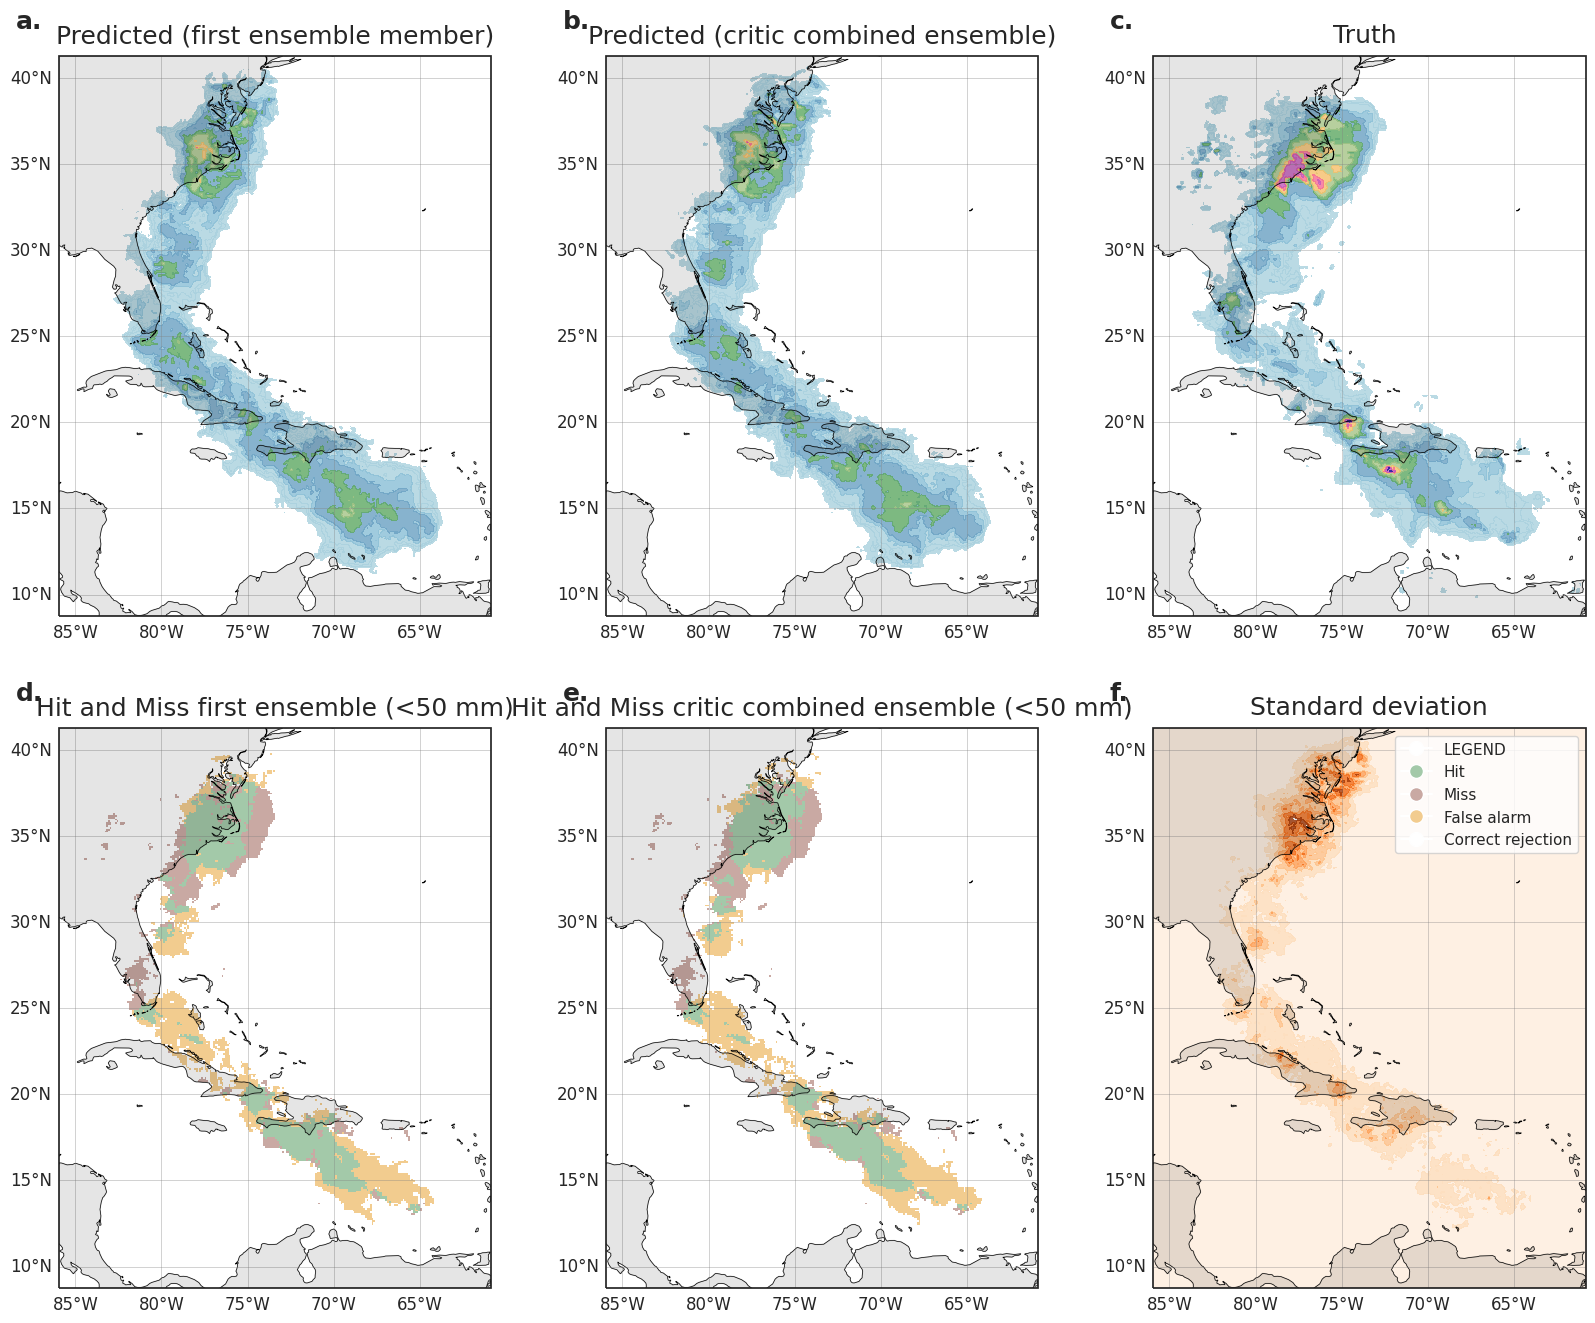

In [85]:
# levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
# sns.set_style("white")
# sns.set_context("notebook")
# vmin=-2
# vmax=2

# TODO: add in combination of ensemble members. Not the mean, but based on the critic score of each image - e.g. the ones which are the best quality are the ones we select

levels = [10, 15, 20, 25, 30, 40, 50,75, 100,140,180,200,250,300]
sns.set_style("white")
sns.set_context("notebook")
vmin=0
vmax=300


fig, axes = plt.subplots(2,3,figsize=(20,16),subplot_kw={'projection': ccrs.PlateCarree()})

rain1 = np.sum(grid_rain2[:,:,:,0],axis=0) > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_mwgan_parts12 = hit + 2* miss + 3* false_alarm + 4*correct_rejection

rain1 = storm_rain_combo > 50
rain2 = np.sum(grid_rain_truth,axis=0) > 50
hit = (rain1 == True) & (rain2 == True)
miss = (rain1 == False) & (rain2 == True)
false_alarm = (rain1 == True) & (rain2 == False)
correct_rejection = (rain1 == False) & (rain2 == False)
rain_data_combo = hit + 2* miss + 3* false_alarm + 4*correct_rejection

# Create a colormap with distinct colors
colors = ['white', '#A3C9A9', '#C9A9A3', '#f2cc8f','white']
cmap = mcolors.ListedColormap(colors)

# Create color boundaries
bounds = np.arange(1, 5, 1)

# Create a BoundaryNorm instance
norm = mcolors.BoundaryNorm(bounds, cmap.N, extend='both')
# norm = mcolors.BoundaryNorm(bounds, cmap.N)

# first panel
axes[0,0].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# second panel
axes[0,1].contourf(grid_x,grid_y,storm_rain_combo,vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# third panel
m = axes[0,2].contourf(grid_x,grid_y,np.sum(grid_rain_truth,axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)

# fourth panel
h = axes[1,0].pcolormesh(grid_x,grid_y,rain_data_mwgan_parts12,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)

# axes[1,1].contourf(grid_x,grid_y,np.sum(grid_rain2[:,:,:,0],axis=0),vmin=vmin,vmax=vmax,levels=levels,cmap = precip_cmap, transform=ccrs.PlateCarree(),alpha=0.8)
# fifth panel
h = axes[1,1].pcolormesh(grid_x,grid_y,rain_data_combo,cmap=cmap, transform=ccrs.PlateCarree(), shading='auto', norm=norm)


# sixth panel hit and miss mwgan part 1 and 2
stand_dev = np.std(np.sum(grid_rain2[:,:,:,:],axis=0),axis=-1)
axes[1,2].contourf(grid_x,grid_y,stand_dev,vmin=0,vmax=40,levels=[0,5,10,15,20,30,40],cmap = 'Oranges', transform=ccrs.PlateCarree(),alpha=0.8)


for i in range(3):
	for j in range(2):
		axes[j,i].add_feature(cfeature.COASTLINE,linewidth=0.5)
		axes[j,i].add_feature(cfeature.LAND, zorder=100,color='black',alpha=0.1)


		# ax.outline_patch.set_linewidth(0.5)
		gl = axes[j,i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
					linewidth=0.5, color='gray', alpha=0.5, linestyle='-')
		gl.xlabels_top = False
		gl.ylabels_right = False
		gl.xlabel_style = {'size': 12}
		gl.ylabel_style = {'size': 12}
		# ax.set_xticklabels(labelsize=20)
		# ax.set_yticklabels(labelsize=20)
		axes[j,i].tick_params(axis='x', labelsize=14)
		axes[j,i].tick_params(axis='y', labelsize=14)

	# precip_cmap,precip_norm = make_cmap(high_vals=True)
	# cbar = plt.colorbar(h, ticks=np.arange(0.5, 4.5, 1), boundaries=bounds, label='Rain Category')
		axes[j,i].set_extent([grid_x[0,0], grid_x[-1,-1], grid_y[0,0], grid_y[-1,-1]], crs=ccrs.PlateCarree())
	# ax.set_title('Hit and Miss',fontsize=18,pad=15)

axes[0,0].text(-0.1, 1.05, 'a.', transform=axes[0,0].transAxes, size=18, weight='bold')
axes[0,1].text(-0.1, 1.05, 'b.', transform=axes[0,1].transAxes, size=18, weight='bold')
axes[0,2].text(-0.1, 1.05, 'c.', transform=axes[0,2].transAxes, size=18, weight='bold')
axes[1,0].text(-0.1, 1.05, 'd.', transform=axes[1,0].transAxes, size=18, weight='bold')
axes[1,1].text(-0.1, 1.05, 'e.', transform=axes[1,1].transAxes, size=18, weight='bold')
axes[1,2].text(-0.1, 1.05, 'f.', transform=axes[1,2].transAxes, size=18, weight='bold')
legend_labels = ['LEGEND', 'Hit', 'Miss', 'False alarm','Correct rejection']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for color, label in zip(colors, legend_labels)]
axes[1,2].legend(handles=legend_handles, loc='upper right')

axes[0,0].set_title('Predicted (first ensemble member)',fontsize=18,pad=10)
axes[0,1].set_title('Predicted (critic combined ensemble)',fontsize=18,pad=10)
axes[0,2].set_title('Truth ',fontsize=18,pad=10)
axes[1,0].set_title('Hit and Miss first ensemble (<50 mm)',fontsize=18,pad=10)
axes[1,1].set_title('Hit and Miss critic combined ensemble (<50 mm)',fontsize=18,pad=10)
axes[1,2].set_title('Standard deviation',fontsize=18,pad=10)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[0])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)

# cbar = plt.colorbar(m,fraction=1.5, pad=-0.7,cmap=precip_cmap,ticks=levels,boundaries=levels, format='%1i',cax=axes[1])
# cbar.ax.tick_params(labelsize=8,width=0.5)
# cbar.ax.tick_params(labelsize=20)


plt.savefig('figure_7d_combination.png',bbox_inches='tight')

# TODO: compare hit miss and ets of combined score vs max and first,second,third etc

# TODO: rainfall is gamma distribution so std not that meaningful, so plot most probable rainfall (not mean) up to 95th percentile


[['', 'first', 'combined'], ['Hit rate (%)', '63.71', '65.44'], ['False alarm rate (%)', '0.05', '0.05'], ['Hit rate (%) \n population weighted', '76.64', '68.85'], ['False alarm rate (%) \n population weighted', '0.12', '0.13'], ['Population \n exposed to > 50 mm \n correctly predicted', '13,910,000', '12,490,000'], ['Population \n exposed to > 50 mm \n missed', '4,240,000', '5,650,000'], ['Population \n falsley exposed \n to > 50 mm', '9,320,000', '10,470,000'], ['ETS', '0.38', '0.40']]


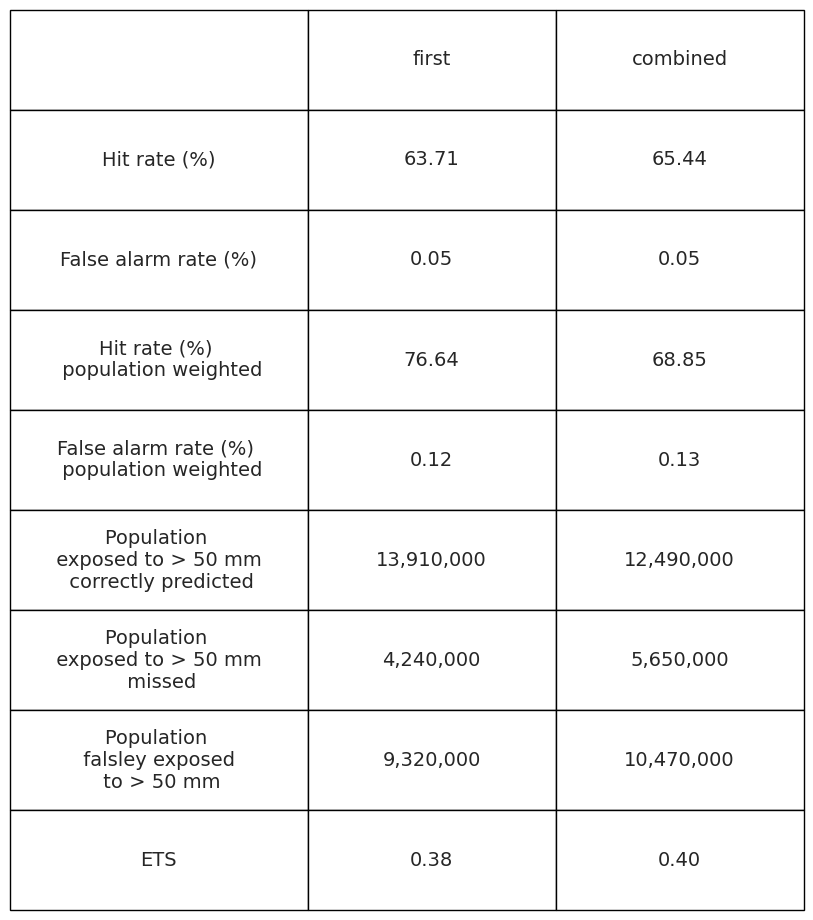

In [86]:
# False alarm rate is so low becuase there are a lot of cells with correct rejection

data = [["", "first", "combined"],
		["Hit rate (%)",f"{hit_rate*100:.2f}",f"{hit_rate2*100:.2f}"],
		["False alarm rate (%)", f"{false_alarm_rate*100:.2f}",f"{false_alarm_rate2*100:.2f}"],
        ["Hit rate (%) \n population weighted",f"{pop_hit_rate*100:.2f}",f"{pop_hit_rate2*100:.2f}"],
		["False alarm rate (%) \n population weighted",f"{pop_false_alarm_rate*100:.2f}",f"{pop_false_alarm_rate2*100:.2f}"],
		["Population \n exposed to > 50 mm \n correctly predicted",f"{round(pop_hit,-4):,.0f}",f"{round(pop_hit2,-4):,.0f}"],
        ["Population \n exposed to > 50 mm \n missed",f"{round(pop_miss,-4):,.0f}",f"{round(pop_miss2,-4):,.0f}"],
		["Population \n falsley exposed \n to > 50 mm",f"{round(pop_false_alarm,-4):,.0f}",f"{round(pop_false_alarm2,-4):,.0f}"],
		["ETS",f"{ETS:.2f}",f"{ETS2:.2f}"]]
# data = [[f'Row {i}, Col {j}' for j in range(4)] for i in range(6)]
print(data)
plt.axis('off')
table = plt.table(cellText=data, loc='center', cellLoc='center')
# Modify the table properties if needed
table.auto_set_font_size(False)
table.set_fontsize(14)
# table.set_edgecolor('white')
cell_dict = table.get_celld()
table.scale(1.5,6)
for i in range(9):
    cell_dict[(i,0)].set_width(0.6)
    
plt.savefig('figure_7b_table.png')


In [ ]:
# now do for all storms and plot a box and whisker of all of them in the test set and extreme test set

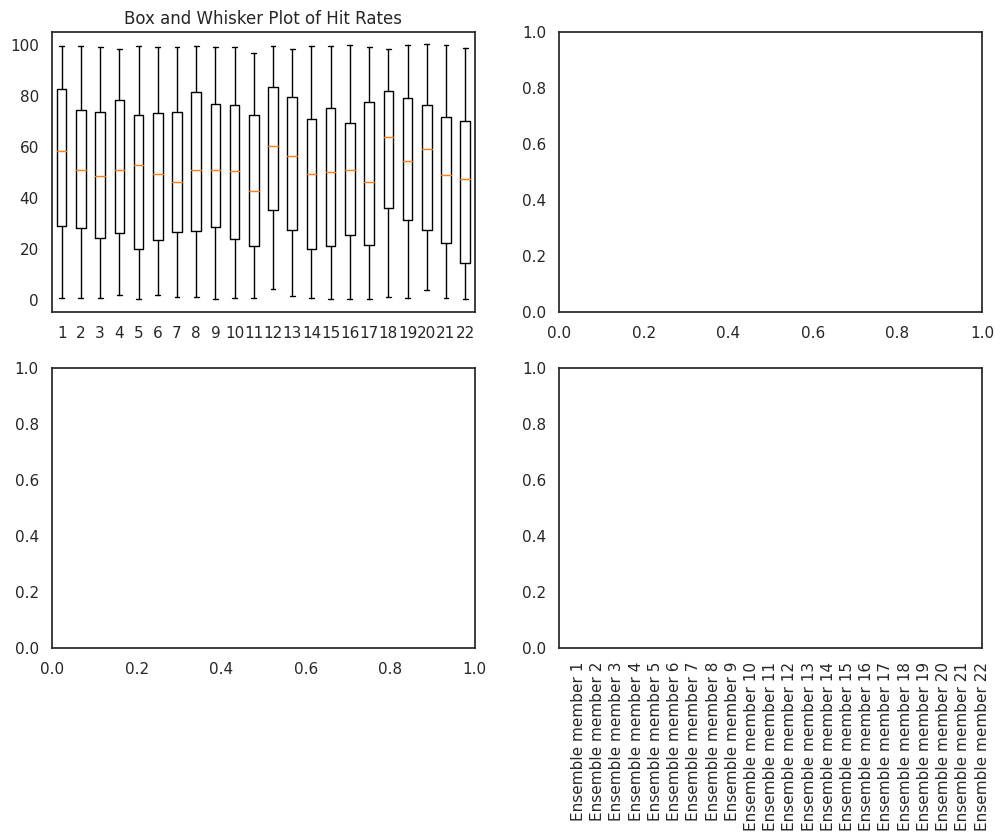

In [93]:
# Sample data
categories = ['Ensemble member {}'.format(i) for i in range(1, 23)]
hit_rates = np.random.uniform(0, 100, size=(100, 22))  # Example hit rates, replace with your actual data

# Create the box and whisker plot
# Create a 2x2 subplot layout
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0,0].boxplot(hit_rates, vert=True)
axes[0,0].set_ylabel('Hit Rate')
axs[0,0].set_title('Box and Whisker Plot of Hit Rates')

# Rotate x-axis labels vertically
# plt.xticks(rotation=90)
# plt.xticks(range(1, 23), categories)

plt.show()

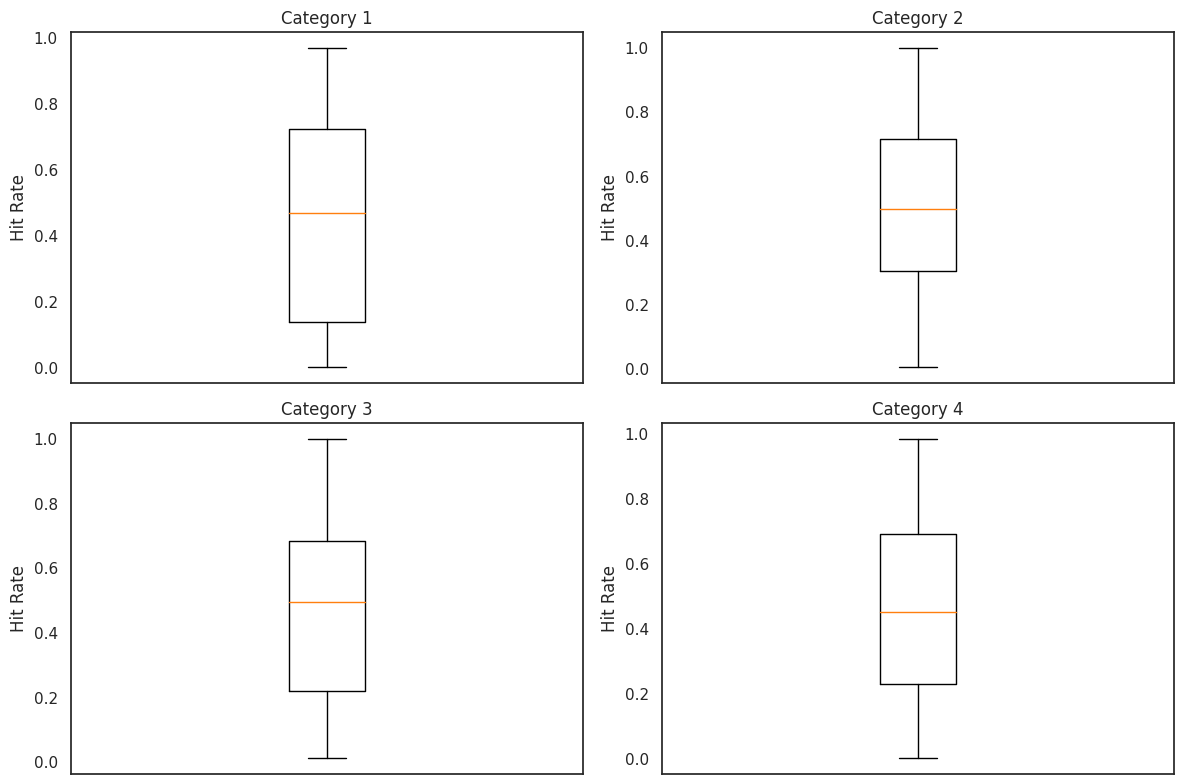